In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.spatial import distance
from sklearn import decomposition
import pickle

pd.set_option('display.max_columns', None)

redundant = ['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s', 'Matches', '-9999']

general = pd.read_csv(r'Data/1_standard.csv').drop(['Rk', 'Matches', '-9999'], axis=1)
shooting = pd.read_csv(r'Data/2_shooting.csv').drop(redundant, axis=1)
passing = pd.read_csv(r'Data/3_passing.csv').drop(redundant, axis=1)
passing_types = pd.read_csv(r'Data/4_passing_types.csv').drop(redundant, axis=1)
gca = pd.read_csv(r'Data/5_gca.csv').drop(redundant, axis=1)
defense = pd.read_csv(r'Data/6_defense.csv').drop(redundant, axis=1)
possession = pd.read_csv(r'Data/7_possession.csv').drop(redundant, axis=1)
misc = pd.read_csv(r'Data/8_misc.csv').drop(redundant, axis=1)
goalkeeper = pd.read_csv(r'Data/gk.csv').drop(redundant, axis=1)
goalkeeper_advance = pd.read_csv(r'Data/gka.csv').drop(redundant, axis=1)

In [2]:
general.Pos.value_counts()

DF      884
MF      714
FW      318
MFFW    312
FWMF    227
GK      217
DFMF    111
MFDF     92
DFFW     32
FWDF     13
Name: Pos, dtype: int64

In [3]:
def rename_columns(table_num, df):
    num = str(table_num) + "_"
    return df.rename(columns=lambda x: num+x)

shooting = rename_columns(2, shooting)
passing = rename_columns(3, passing)
passing_types = rename_columns(4,passing_types)
gca = rename_columns(5, gca)
defense = rename_columns(6, defense)
possession = rename_columns(7, possession)
misc = rename_columns(8, misc)

outfield_dataset = pd.concat([general,shooting, passing, passing_types, gca, defense, possession, misc], axis=1)
outfield_dataset

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls.1,Ast.1,G+A,G-PK.1,G+A-PK,xG,npxG,xAG,npxG+xAG,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,2_Gls,2_Sh,2_SoT,2_SoT%,2_Sh/90,2_SoT/90,2_G/Sh,2_G/SoT,2_Dist,2_FK,2_PK,2_PKatt,2_xG,2_npxG,2_npxG/Sh,2_G-xG,2_np:G-xG,3_Cmp,3_Att,3_Cmp%,3_TotDist,3_PrgDist,3_Cmp.1,3_Att.1,3_Cmp%.1,3_Cmp.2,3_Att.2,3_Cmp%.2,3_Cmp.3,3_Att.3,3_Cmp%.3,3_Ast,3_xAG,3_xA,3_A-xAG,3_KP,3_1/3,3_PPA,3_CrsPA,3_Prog,4_Att,4_Live,4_Dead,4_FK,4_TB,4_Sw,4_Crs,4_TI,4_CK,4_In,4_Out,4_Str,4_Cmp,4_Off,4_Blocks,5_SCA,5_SCA90,5_PassLive,5_PassDead,5_Drib,5_Sh,5_Fld,5_Def,5_GCA,5_GCA90,5_PassLive.1,5_PassDead.1,5_Drib.1,5_Sh.1,5_Fld.1,5_Def.1,6_Tkl,6_TklW,6_Def 3rd,6_Mid 3rd,6_Att 3rd,6_Tkl.1,6_Att,6_Tkl%,6_Past,6_Blocks,6_Sh,6_Pass,6_Int,6_Tkl+Int,6_Clr,6_Err,7_Touches,7_Def Pen,7_Def 3rd,7_Mid 3rd,7_Att 3rd,7_Att Pen,7_Live,7_Succ,7_Att,7_Succ%,7_Mis,7_Dis,7_Rec,7_Prog,8_CrdY,8_CrdR,8_2CrdY,8_Fls,8_Fld,8_Off,8_Crs,8_Int,8_TklW,8_PKwon,8_PKcon,8_OG,8_Recov,8_Won,8_Lost,8_Won%
0,Max Aarons,eng ENG,DF,Norwich City,eng Premier League,21.0,2000.0,34,32,2881,32.0,0.00,0.06,0.00,0.00,0.00,0.25,0.00,0.00,0.06,0.06,0.00,0.06,0.03,0.03,0.05,0.08,0.03,0.05,0.08,0.03,0.08,0.00,0.41,0.06,15.4,0.41,0.06,0.00,0.00,19.9,0.00,0.00,0.00,0.03,0.03,0.07,-0.03,-0.03,34.6,45.9,75.4,518.4,191.7,20.2,22.3,90.5,12.00,16.00,75.0,1.78,5.00,35.6,0.06,0.05,0.05,0.01,0.63,1.56,1.16,0.28,2.69,1469.0,1130.0,332.0,17.0,5.0,4.0,50,315.0,0.0,0.0,0.0,0.0,1107.0,7.0,40.0,47.0,1.47,34.0,3.0,2.0,3.0,3.0,2.0,3.0,0.09,3.0,0.0,0.0,0.0,0.0,0.0,64.0,44,49.0,15.0,0.0,37.0,55.0,67.3,18.0,39.0,19.0,20.0,28,92.0,96.0,1.0,1817.0,159.0,714.0,694.0,434.0,23.0,1817.0,34.0,68.0,50.0,38.0,23.0,1018.0,40.0,0.25,0.00,0.00,0.84,1.63,0.03,1.56,0.88,1.38,0.00,0.06,0.03,4.81,0.41,1.56,20.6
1,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,33.0,1987.0,34,34,2983,33.1,0.06,0.00,0.06,0.00,0.00,0.15,0.03,0.06,0.00,0.06,0.06,0.06,0.05,0.05,0.03,0.07,0.04,0.03,0.07,0.04,0.07,0.06,0.54,0.18,33.3,0.54,0.18,0.11,0.33,18.3,0.00,0.00,0.00,0.05,0.05,0.08,0.02,0.02,38.8,47.7,81.4,770.9,289.6,12.5,14.2,88.5,21.60,23.80,90.9,4.38,8.04,54.5,0.00,0.03,0.02,-0.03,0.27,2.87,0.21,0.00,2.90,1578.0,1471.0,101.0,89.0,0.0,32.0,4,9.0,0.0,0.0,0.0,0.0,1284.0,6.0,26.0,25.0,0.75,16.0,0.0,2.0,1.0,0.0,6.0,1.0,0.03,1.0,0.0,0.0,0.0,0.0,0.0,48.0,27,34.0,14.0,0.0,16.0,32.0,50.0,16.0,50.0,25.0,25.0,68,116.0,104.0,0.0,1906.0,212.0,1012.0,839.0,84.0,24.0,1906.0,14.0,18.0,77.8,28.0,13.0,1199.0,10.0,0.15,0.03,0.00,1.18,0.76,0.00,0.12,2.05,0.82,0.00,0.03,0.00,5.89,1.87,1.15,62.0
2,Salis Abdul Samed,gh GHA,MF,Clermont Foot,fr Ligue 1,21.0,2000.0,31,29,2462,27.4,0.04,0.00,0.04,0.00,0.00,0.44,0.11,0.04,0.00,0.04,0.04,0.04,0.04,0.04,0.04,0.07,0.04,0.04,0.07,0.04,0.07,0.04,0.66,0.18,27.8,0.66,0.18,0.06,0.20,21.5,0.00,0.00,0.00,0.04,0.04,0.06,-0.00,-0.00,56.0,62.1,90.2,931.3,199.1,27.3,29.4,92.9,23.90,25.50,93.7,3.94,4.71,83.7,0.00,0.04,0.03,-0.04,0.62,3.18,0.47,0.04,2.92,1701.0,1678.0,21.0,17.0,1.0,3.0,14,4.0,0.0,0.0,0.0,0.0,1535.0,2.0,29.0,53.0,1.94,41.0,0.0,0.0,4.0,4.0,4.0,4.0,0.15,3.0,0.0,0.0,0.0,0.0,1.0,43.0,23,25.0,16.0,2.0,20.0,57.0,35.1,37.0,18.0,1.0,17.0,42,85.0,15.0,0.0,1943.0,39.0,562.0,1140.0,257.0,15.0,1943.0,26.0,41.0,63.4,42.0,30.0,1477.0,41.0,0.44,0.11,0.07,1.57,1.35,0.00,0.51,1.53,0.84,0.00,0.00,0.00,6.79,0.62,0.73,45.9
3,Laurent Abergel,fr FRA,MF,Lorient,fr Ligue 1,28.0,1993.0,34,34,2956,32.8,0.00,0.06,0.00,0.00,0.00,0.27,0.00,0.00,0.06,0.06,0.00,0.06,0.06,0.06,0.13,0.20,0.06,0.13,0.20,0.06,0.20,0.00,0.88,0.21,24.1,0.88,0.21,0.00,0.00,24.2,0.00,0.00,0.00,0.06,0.06,0.07,-0.06,-0.06,40.9,50.6,80.8,724.2,208.7,18.4,20.7,89.2,16.30,18.90,86.3,4.63,7.20,64.4,0.06,0.13,0.08,-0.07,1.07,4.48,0.70,0.27,3.84,1659.0,1616.0,35.0,25.0,7.0,21.0,37,8.0,2.0,0.0,1.0,0.0,1341.0,8.0,48.0,82.0,2.50,65.0,2.0,3.0,1.0,7.0,4.0,9.0,0.27,8.0,0.0,0.0,0.0,1.0,0.0,110.0,60,44.0,53.0,13.0,71.0,166.0,42.8,95.0,58.0,1.0,57.0,55,165.0,13.0,0.0,2020.0,24.0,405.0,1286.0,358.0,14.0,2020.0,39.0,61.0,63.9,52.0,40.0,1

In [4]:
goalkeeper = rename_columns(2, goalkeeper)
goalkeeper_advance = rename_columns(3, goalkeeper_advance)

gk_dataset = pd.concat([general[general["Pos"] == 'GK'], goalkeeper, goalkeeper_advance], axis=1)
gk_dataset

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls.1,Ast.1,G+A,G-PK.1,G+A-PK,xG,npxG,xAG,npxG+xAG,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,2_MP,2_Starts,2_Min,2_GA,2_GA90,2_SoTA,2_Saves,2_Save%,2_W,2_D,2_L,2_CS,2_CS%,2_PKatt,2_PKA,2_PKsv,2_PKm,2_Save%.1,3_GA,3_PKA,3_FK,3_CK,3_OG,3_PSxG,3_PSxG/SoT,3_PSxG+/-,3_/90,3_Cmp,3_Att,3_Cmp%,3_Att.1,3_Thr,3_Launch%,3_AvgLen,3_Att.2,3_Launch%.1,3_AvgLen.1,3_Opp,3_Stp,3_Stp%,3_#OPA,3_#OPA/90,3_AvgDist
22,Julen Agirrezabala,es ESP,GK,Athletic Club,es La Liga,20.0,2000.0,4.0,4.0,360.0,4.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,31.0,31.0,2790.0,0.77,0.77,3.23,2.42,78.0,0.45,0.42,0.13,0.42,41.9,0.13,0.06,0.03,0.03,33.3,0.77,0.06,0.06,0.19,0.00,0.86,0.24,0.08,0.09,4.90,12.20,40.2,26.7,3.74,30.2,33.1,7.77,53.1,41.2,13.5,0.87,6.4,0.77,0.77,12.8
60,Doğan Alemdar,tr TUR,GK,Rennes,fr Ligue 1,18.0,2002.0,12.0,12.0,1080.0,12.0,0.0,0.00,0.0,0.0,0.0,0.08,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,13.0,13.0,1166.0,2.23,2.24,6.23,3.92,65.4,0.08,0.31,0.54,0.15,15.4,0.15,0.08,0.08,0.00,50.0,2.23,0.08,0.00,0.62,0.00,1.81,0.27,-0.42,-0.42,4.54,11.80,38.3,22.0,5.08,41.6,36.2,7.08,38.0,34.9,13.6,0.69,5.1,1.62,1.62,18.1
65,Alisson,br BRA,GK,Liverpool,eng Premier League,28.0,1992.0,36.0,36.0,3240.0,36.0,0.0,0.03,0.0,0.0,0.0,0.00,0.0,0.0,0.03,0.03,0.0,0.03,0.0,0.0,0.03,0.03,0.0,0.03,0.03,0.0,0.03,26.0,26.0,2340.0,1.88,1.88,4.46,2.58,60.3,0.19,0.19,0.62,0.15,15.4,0.15,0.12,0.04,0.00,25.0,1.88,0.12,0.00,0.12,0.04,1.43,0.29,-0.42,-0.42,7.54,23.90,31.5,25.3,2.92,64.1,44.7,8.58,90.1,60.6,17.5,0.77,4.4,1.42,1.42,15.8
115,Alphonse Areola,fr FRA,GK,West Ham,eng Premier League,28.0,1993.0,1.0,1.0,90.0,1.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,1.0,0.0,11.0,0.00,0.00,10.00,10.00,100.0,0.00,0.00,0.00,10.00,NaN,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,1.00,0.05,1.00,0.44,0.00,0.00,NaN,10.0,10.00,0.0,15.0,0.00,NaN,NaN,10.0,0.00,0.0,0.00,0.00,NaN
123,Kepa Arrizabalaga,es ESP,GK,Chelsea,eng Premier League,26.0,1994.0,4.0,4.0,360.0,4.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,27.0,27.0,2430.0,1.22,1.22,2.96,1.70,67.5,0.33,0.26,0.41,0.15,14.8,0.30,0.26,0.04,0.00,12.5,1.22,0.26,0.07,0.15,0.00,0.99,0.24,-0.23,-0.23,7.11,24.40,29.1,31.4,3.59,59.5,44.4,6.26,91.1,66.3,10.7,0.67,6.2,0.81,0.81,14.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,360.0,3.00,3.00,5.50,2.25,54.5,0.00,0.25,0.75,0.00,0.0,0.75,0.50,0.25,0.00,33.3,3.00,0.50,0.00,0.00,0.00,2.20,0.29,-0.80,-0.80,5.75,16.50,34.8,19.8,2.75,50.6,38.1,9.75,66.7,47.9,13.8,0.75,5.5,0.00,0.00,7.8
214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,32.0,2880.0,1.31,1.31,3.75,2.44,68.3,0.38,0.19,0.44,0.31,31.3,0.16,0.13,0.03,0.00,20.0,1.31,0.13,0.00,0.13,0.03,1.22,0.29,-0.06,-0.06,3.72,12.20,30.6,23.9,5.19,36.9,34.4,7.38,44.9,39.4,13.2,0.91,6.9,2.13,2.13,17.9
215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,645.0,1.81,1.81,5.14,3.33,64.9,0.00,0.14,0.83,0.00,0.0,0.00,0.00,0.00,0.00,NaN,1.81,0.00,0.00,0.14,0.00,1.67,0.33,-0.14,-0.14,5.83,13.10,44.7,24.7,5.83,36.0,34.6,7.36,56.6,46.6,12.5,1.25,10.0,0.83,0.84,11.0
216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,630.0,2.71,2.71,6.14,3.29,58.1,0.14,0.14,0.71,0.00,0

In [5]:
outfield_df = outfield_dataset[outfield_dataset['90s']>=3]
goalkeeper_df = gk_dataset[gk_dataset['90s']>=3]

outfield_df = outfield_df[outfield_df['Pos'] != 'GK'].reset_index()
goalkeeper_df = goalkeeper_df[goalkeeper_df['Pos'] == 'GK'].reset_index()

outfield_df['Player'] = outfield_df['Player'].str.split('\\', expand=True)[0]
goalkeeper_df['Player'] = goalkeeper_df['Player'].str.split('\\', expand=True)[0]

outfield_df['Comp'] = outfield_df['Comp'].str.split(' ', expand=True, n=1)[1]
goalkeeper_df['Comp'] = goalkeeper_df['Comp'].str.split(' ', expand=True, n=1)[1]

In [6]:
outfield_df = outfield_df.fillna(0)
goalkeeper_df = goalkeeper_df.fillna(0)
outfield_df

,index,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,Gls.1,Ast.1,G+A,G-PK.1,G+A-PK,xG,npxG,xAG,npxG+xAG,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,2_Gls,2_Sh,2_SoT,2_SoT%,2_Sh/90,2_SoT/90,2_G/Sh,2_G/SoT,2_Dist,2_FK,2_PK,2_PKatt,2_xG,2_npxG,2_npxG/Sh,2_G-xG,2_np:G-xG,3_Cmp,3_Att,3_Cmp%,3_TotDist,3_PrgDist,3_Cmp.1,3_Att.1,3_Cmp%.1,3_Cmp.2,3_Att.2,3_Cmp%.2,3_Cmp.3,3_Att.3,3_Cmp%.3,3_Ast,3_xAG,3_xA,3_A-xAG,3_KP,3_1/3,3_PPA,3_CrsPA,3_Prog,4_Att,4_Live,4_Dead,4_FK,4_TB,4_Sw,4_Crs,4_TI,4_CK,4_In,4_Out,4_Str,4_Cmp,4_Off,4_Blocks,5_SCA,5_SCA90,5_PassLive,5_PassDead,5_Drib,5_Sh,5_Fld,5_Def,5_GCA,5_GCA90,5_PassLive.1,5_PassDead.1,5_Drib.1,5_Sh.1,5_Fld.1,5_Def.1,6_Tkl,6_TklW,6_Def 3rd,6_Mid 3rd,6_Att 3rd,6_Tkl.1,6_Att,6_Tkl%,6_Past,6_Blocks,6_Sh,6_Pass,6_Int,6_Tkl+Int,6_Clr,6_Err,7_Touches,7_Def Pen,7_Def 3rd,7_Mid 3rd,7_Att 3rd,7_Att Pen,7_Live,7_Succ,7_Att,7_Succ%,7_Mis,7_Dis,7_Rec,7_Prog,8_CrdY,8_CrdR,8_2CrdY,8_Fls,8_Fld,8_Off,8_Crs,8_Int,8_TklW,8_PKwon,8_PKcon,8_OG,8_Recov,8_Won,8_Lost,8_Won%
0,0,Max Aarons,eng ENG,DF,Norwich City,Premier League,21.0,2000.0,34,32,2881,32.0,0.00,0.06,0.00,0.00,0.00,0.25,0.00,0.00,0.06,0.06,0.00,0.06,0.03,0.03,0.05,0.08,0.03,0.05,0.08,0.03,0.08,0.00,0.41,0.06,15.4,0.41,0.06,0.00,0.00,19.9,0.00,0.00,0.00,0.03,0.03,0.07,-0.03,-0.03,34.6,45.9,75.4,518.4,191.7,20.20,22.30,90.5,12.00,16.00,75.0,1.78,5.00,35.6,0.06,0.05,0.05,0.01,0.63,1.56,1.16,0.28,2.69,1469.0,1130.0,332.0,17.0,5.0,4.0,50,315.0,0.0,0.0,0.0,0.0,1107.0,7.0,40.0,47.0,1.47,34.0,3.0,2.0,3.0,3.0,2.0,3.0,0.09,3.0,0.0,0.0,0.0,0.0,0.0,64.0,44,49.0,15.0,0.0,37.0,55.0,67.3,18.0,39.0,19.0,20.0,28,92.0,96.0,1.0,1817.0,159.0,714.0,694.0,434.0,23.0,1817.0,34.0,68.0,50.0,38.0,23.0,1018.0,40.0,0.25,0.00,0.00,0.84,1.63,0.03,1.56,0.88,1.38,0.00,0.06,0.03,4.81,0.41,1.56,20.6
1,1,Yunis Abdelhamid,ma MAR,DF,Reims,Ligue 1,33.0,1987.0,34,34,2983,33.1,0.06,0.00,0.06,0.00,0.00,0.15,0.03,0.06,0.00,0.06,0.06,0.06,0.05,0.05,0.03,0.07,0.04,0.03,0.07,0.04,0.07,0.06,0.54,0.18,33.3,0.54,0.18,0.11,0.33,18.3,0.00,0.00,0.00,0.05,0.05,0.08,0.02,0.02,38.8,47.7,81.4,770.9,289.6,12.50,14.20,88.5,21.60,23.80,90.9,4.38,8.04,54.5,0.00,0.03,0.02,-0.03,0.27,2.87,0.21,0.00,2.90,1578.0,1471.0,101.0,89.0,0.0,32.0,4,9.0,0.0,0.0,0.0,0.0,1284.0,6.0,26.0,25.0,0.75,16.0,0.0,2.0,1.0,0.0,6.0,1.0,0.03,1.0,0.0,0.0,0.0,0.0,0.0,48.0,27,34.0,14.0,0.0,16.0,32.0,50.0,16.0,50.0,25.0,25.0,68,116.0,104.0,0.0,1906.0,212.0,1012.0,839.0,84.0,24.0,1906.0,14.0,18.0,77.8,28.0,13.0,1199.0,10.0,0.15,0.03,0.00,1.18,0.76,0.00,0.12,2.05,0.82,0.00,0.03,0.00,5.89,1.87,1.15,62.0
2,2,Salis Abdul Samed,gh GHA,MF,Clermont Foot,Ligue 1,21.0,2000.0,31,29,2462,27.4,0.04,0.00,0.04,0.00,0.00,0.44,0.11,0.04,0.00,0.04,0.04,0.04,0.04,0.04,0.04,0.07,0.04,0.04,0.07,0.04,0.07,0.04,0.66,0.18,27.8,0.66,0.18,0.06,0.20,21.5,0.00,0.00,0.00,0.04,0.04,0.06,-0.00,-0.00,56.0,62.1,90.2,931.3,199.1,27.30,29.40,92.9,23.90,25.50,93.7,3.94,4.71,83.7,0.00,0.04,0.03,-0.04,0.62,3.18,0.47,0.04,2.92,1701.0,1678.0,21.0,17.0,1.0,3.0,14,4.0,0.0,0.0,0.0,0.0,1535.0,2.0,29.0,53.0,1.94,41.0,0.0,0.0,4.0,4.0,4.0,4.0,0.15,3.0,0.0,0.0,0.0,0.0,1.0,43.0,23,25.0,16.0,2.0,20.0,57.0,35.1,37.0,18.0,1.0,17.0,42,85.0,15.0,0.0,1943.0,39.0,562.0,1140.0,257.0,15.0,1943.0,26.0,41.0,63.4,42.0,30.0,1477.0,41.0,0.44,0.11,0.07,1.57,1.35,0.00,0.51,1.53,0.84,0.00,0.00,0.00,6.79,0.62,0.73,45.9
3,3,Laurent Abergel,fr FRA,MF,Lorient,Ligue 1,28.0,1993.0,34,34,2956,32.8,0.00,0.06,0.00,0.00,0.00,0.27,0.00,0.00,0.06,0.06,0.00,0.06,0.06,0.06,0.13,0.20,0.06,0.13,0.20,0.06,0.20,0.00,0.88,0.21,24.1,0.88,0.21,0.00,0.00,24.2,0.00,0.00,0.00,0.06,0.06,0.07,-0.06,-0.06,40.9,50.6,80.8,724.2,208.7,18.40,20.70,89.2,16.30,18.90,86.3,4.63,7.20,64.4,0.06,0.13,0.08,-0.07,1.07,4.48,0.70,0.27,3.84,1659.0,1616.0,35.0,25.0,7.0,21.0,37,8.0,2.0,0.0,1.0,0.0,1341.0,8.0,48.0,82.0,2.50,65.0,2.0,3.0,1.0,7.0,4.0,9.0,0.27,8.0,0.0,0.0,0.0,1.0,0.0,110.0,60,44.0,53.0,13.0,71.0,166.0,42.8,95.0,58.0,1.0,57.0,55,165.0,13.0,0.0,2020.0,24.0,405.0,1286.0,358.0,14.0,2020.0,39.0,61.0,63.9,52

In [7]:
outfield_df.Player.duplicated().sum(), goalkeeper_df.duplicated().sum()

(46, 0)

In [8]:
players_outfield = []
players_gk = []

for i in range(len(outfield_df)):
    players_outfield.append(outfield_df['Player'][i] + '({})'.format(outfield_df['Squad'][i]))

for i in range(len(goalkeeper_df)):
    players_gk.append(goalkeeper_df['Player'][i] + '({})'.format(goalkeeper_df['Squad'][i]))
    
player_Id_outfield = dict(zip(players_outfield, np.arange(len(players_outfield))))
player_Id_gk = dict(zip(players_gk, np.arange(len(players_gk))))

player_Id_outfield, player_Id_gk

({'Max Aarons(Norwich City)': 0,
  'Yunis Abdelhamid(Reims)': 1,
  'Salis Abdul Samed(Clermont Foot)': 2,
  'Laurent Abergel(Lorient)': 3,
  'Dickson Abiama(Greuther Fürth)': 4,
  'Tammy Abraham(Roma)': 5,
  'Luis Abram(Granada)': 6,
  'Francesco Acerbi(Lazio)': 7,
  'Marcos Acuña(Sevilla)': 8,
  'Che Adams(Southampton)': 9,
  'Tyler Adams(RB Leipzig)': 10,
  'Sargis Adamyan(Hoffenheim)': 11,
  'Martin Adeline(Reims)': 12,
  'Amine Adli(Leverkusen)': 13,
  'Yacine Adli(Bordeaux)': 14,
  'Michel Aebischer(Bologna)': 15,
  'Felix Afena-Gyan(Roma)': 16,
  'Martin Agirregabiria(Alavés)': 17,
  'Lucien Agoume(Brest)': 18,
  'Kevin Agudelo(Spezia)': 19,
  'Nayef Aguerd(Rennes)': 20,
  'Ruben Aguilar(Monaco)': 21,
  'Anel Ahmedhodzic(Bordeaux)': 22,
  'Jean-Eudes Aholou(Strasbourg)': 23,
  'Joseph Aidoo(Celta Vigo)': 24,
  'Ola Aina(Torino)': 25,
  'Rayan Aït Nouri(Wolves)': 26,
  'Kristoffer Ajer(Brentford)': 27,
  'Ludovic Ajorque(Strasbourg)': 28,
  'Manuel Akanji(Dortmund)': 29,
  'Carlos

Text(0.5, 0.98, 'Postion distribution among leagues')

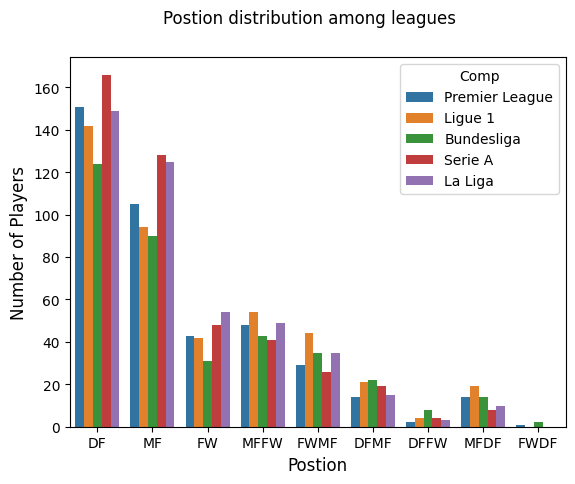

In [9]:
ax = sns.countplot(x="Pos", hue='Comp', data=outfield_df) #No need for goalkeepers
plt.xlabel('Postion',size=12)
plt.ylabel('Number of Players', size=12)
plt.suptitle('Postion distribution among leagues')

Text(0.5, 0.98, 'Outfield Player Age Distribution')

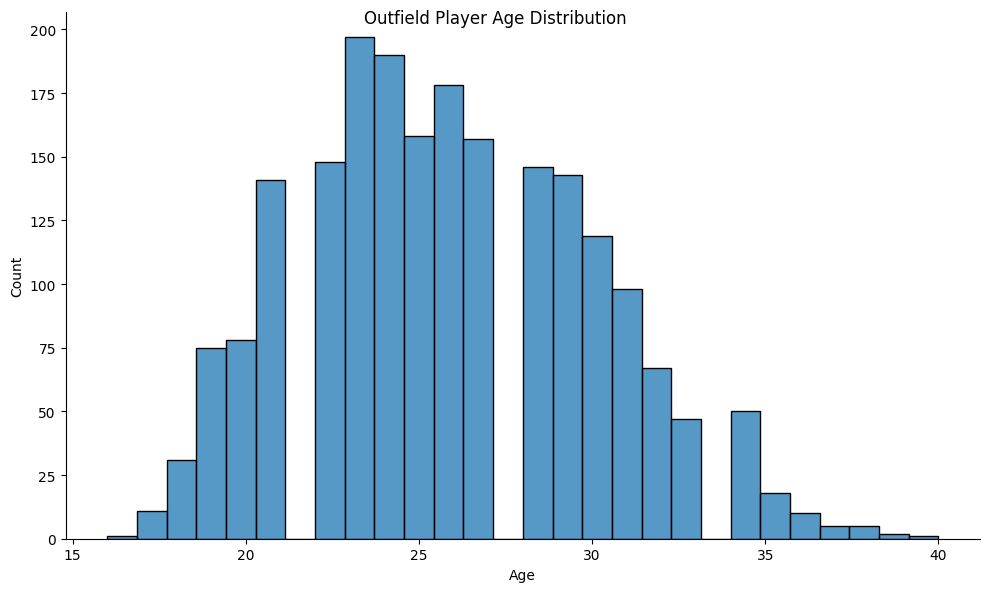

In [10]:
sns.FacetGrid(outfield_df, height=6, aspect=10/6).map(sns.histplot, "Age", bins=28)
plt.suptitle("Outfield Player Age Distribution")

Text(0.5, 0.98, 'Goalkeeper Age Distribution')

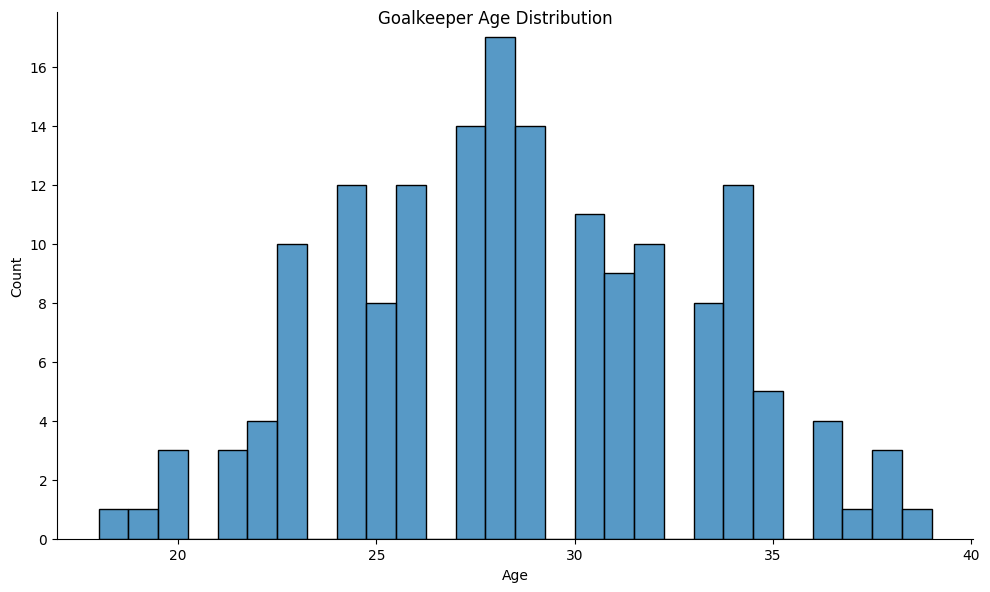

In [11]:
sns.FacetGrid(goalkeeper_df, height=6, aspect=10/6).map(sns.histplot, "Age", bins=28)
plt.suptitle("Goalkeeper Age Distribution")

Text(0.5, 0.98, 'Age variation outfield')

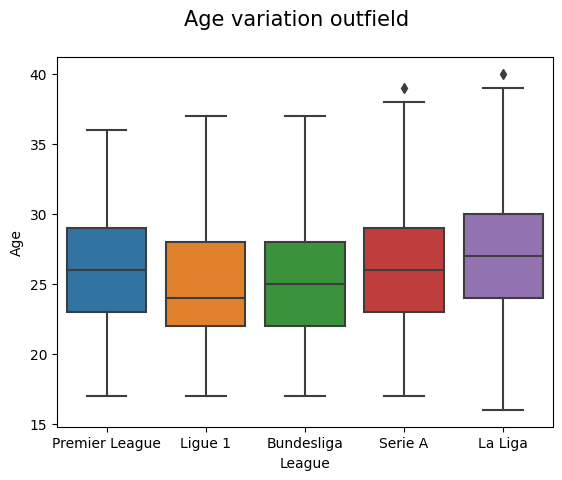

In [12]:
ax = sns.boxplot(x='Comp', y='Age', data=outfield_df)
plt.xlabel('League')
plt.suptitle('Age variation outfield', size=15)

Text(0.5, 0.98, 'Age variation Goalkeeper')

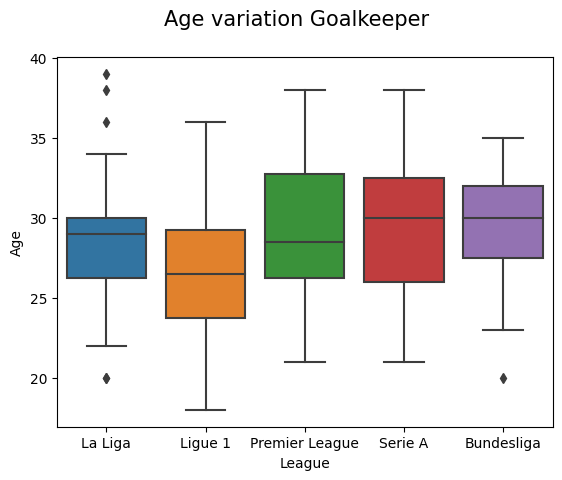

In [13]:
ax = sns.boxplot(x='Comp', y='Age', data=goalkeeper_df)
plt.xlabel('League')
plt.suptitle('Age variation Goalkeeper', size=15)

In [14]:
scaler_outfield = StandardScaler()
scaler_goalkeeper = StandardScaler()

stats_outfield = outfield_df.iloc[:, 12:-1]
labels_outfield = outfield_df['Pos']
stats_goalkeeper = goalkeeper_df.iloc[:, 12:-1]
labels_goalkeeper = goalkeeper_df['Pos']

data_outfield = scaler_outfield.fit_transform(stats_outfield)
data_goalkeeper = scaler_goalkeeper.fit_transform(stats_goalkeeper)

/Users/rohanchoudhary/tensorflow-test/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rohanchoudhary/tensorflow-test/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 't-SNE - Outfield players')

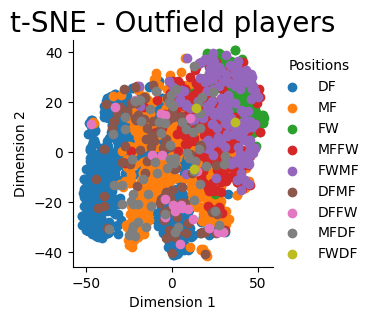

In [15]:
model_outfield = TSNE(n_components=2, perplexity=30, random_state=0)
tsne_data_outfield = model_outfield.fit_transform(data_outfield)

tsne_data_outfield = np.vstack((tsne_data_outfield.T, labels_outfield)).T
tsne_df_outfield = pd.DataFrame(data=tsne_data_outfield, columns=("Dimension 1", "Dimension 2", "Positions"))

ax = sns.FacetGrid(tsne_df_outfield, hue="Positions").map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title('t-SNE - Outfield players', size=20)

Text(0.5, 1.0, 'PCA: components selection for outfield players')

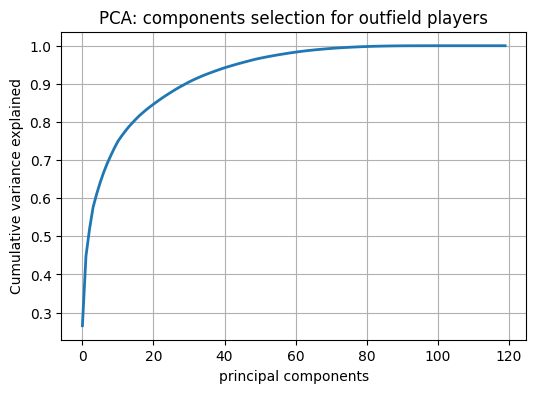

In [16]:
pca = decomposition.PCA()
pca.n_components = 120
pca_data_outfield = pca.fit_transform(data_outfield)

percentage_var_explained_outfield = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained_outfield = np.cumsum(percentage_var_explained_outfield)

plt.figure(1, figsize=(6, 4))
plt.plot(cum_var_explained_outfield, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('principal components')
plt.ylabel('Cumulative variance explained')
plt.title('PCA: components selection for outfield players')

Text(0.5, 1.0, 'PCA: components selection for goalkeepers')

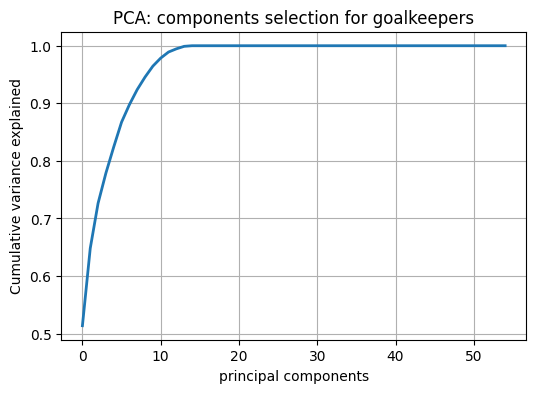

In [17]:
pca = decomposition.PCA()
pca.n_components = 55
pca_data_goalkeeper = pca.fit_transform(data_goalkeeper)

percentage_var_explained_goalkeeper = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained_goalkeeper = np.cumsum(percentage_var_explained_goalkeeper)

plt.figure(1, figsize=(6, 4))
plt.plot(cum_var_explained_goalkeeper, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('principal components')
plt.ylabel('Cumulative variance explained')
plt.title('PCA: components selection for goalkeepers')

In [18]:
stats_outfield = pca_data_outfield[:,:65]
stats_goalkeeper = pca_data_goalkeeper[:,:13]
temp_outfield = pd.DataFrame(data=stats_outfield)
temp_goalkeeper = pd.DataFrame(data=stats_goalkeeper)
temp_outfield

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,-5.401206,4.847288,-1.762352,-4.990726,0.738540,-1.069802,1.693697,-1.496654,1.826467,0.570609,3.242660,-0.203940,0.882562,-0.028069,0.206159,1.681918,-1.538438,-0.136612,0.826359,0.774930,-1.369286,-0.358636,1.958379,0.647432,-0.477605,1.008673,-0.084965,1.568599,-0.096978,1.469590,0.013025,-0.291283,-1.465656,-0.276530,-0.012235,-1.066118,-0.276824,0.509342,0.249259,0.770335,-0.017451,0.430738,1.395302,-1.209044,-0.476461,-0.422622,-1.104174,-0.269099,0.434308,-0.045926,0.462994,0.162997,0.496075,0.123276,-0.761792,0.445265,0.413592,0.229614,-0.015937,0.367372,0.111879,0.126220,0.102729,0.198917,-0.082535
1,-7.962728,3.319919,-5.311891,-0.057616,2.351319,-0.127388,0.936693,1.388528,-0.974520,-0.143912,-0.584905,1.275422,-0.353888,-2.200931,1.077526,0.124709,-0.846870,-0.362764,0.328335,-0.319217,0.213254,-0.722851,-0.813619,0.278971,0.919633,-0.057143,-1.900339,0.505311,1.698707,0.287755,0.018659,-0.511020,0.726319,-0.019201,-1.767651,0.447600,-0.986915,0.928485,-0.403198,0.182864,-0.116341,-0.965023,0.515511,0.583111,0.167326,-1.072885,-0.585112,-0.184011,0.086324,0.483046,0.197816,1.103102,0.468783,-0.167644,0.122947,-0.160622,0.135046,-0.397767,0.889029,-0.723297,-0.024368,-1.345335,-0.157337,0.422700,-0.280387
2,-5.825097,3.914661,-1.732399,0.014243,-3.628234,1.189292,-2.949546,3.037848,0.113976,3.073751,0.808875,1.699247,-0.740160,1.716277,0.677838,-1.087026,-1.148435,1.176228,2.612212,-0.310693,0.160404,-0.107612,-1.673546,-0.144845,0.780408,0.225470,-0.725472,-0.895914,1.435862,-0.491281,-0.357135,0.030632,0.006550,1.324045,0.339469,0.242662,-0.167601,-0.737555,0.079844,-0.981239,0.092357,1.238617,-0.518505,-1.103246,0.293145,0.488475,0.429833,1.030303,0.571311,0.467906,0.213710,-0.326924,0.438632,0.032759,-0.697518,-0.346912,0.397084,0.084751,-0.016906,0.854173,0.214176,-0.823151,-0.692114,0.172969,0.201257
3,-4.979070,12.451754,-3.156307,-7.469859,-5.167023,-0.445327,-3.050102,1.109461,-1.426935,-4.242433,-0.769795,1.638696,-0.494189,-0.375527,0.687912,-0.722086,-0.212546,1.366851,-2.617439,0.368708,0.921099,-0.568350,0.574349,-0.365436,-0.910320,-1.201166,-0.723404,-0.053379,0.091970,-1.394633,-0.595967,-0.126852,-0.859311,1.219307,1.880586,-1.160463,-1.193094,-0.365162,-1.088773,-0.750912,0.612882,0.086446,-0.087445,-0.167125,0.334071,-1.026298,1.527668,1.529815,-1.611828,0.456216,-0.210271,-1.793604,-1.113490,-0.302012,-0.590511,-0.336909,0.353858,0.149376,0.555355,0.107813,0.376469,-0.911919,-0.362281,-0.617618,0.446899
4,5.064473,-6.614975,0.460079,-4.064955,-0.397088,2.681934,2.769478,1.575499,-1.848266,-1.963885,1.003478,-1.552286,-1.294621,0.399501,-1.014154,-0.904423,-0.701661,0.077904,0.401632,-0.077879,0.108682,0.227100,-0.176568,0.203254,0.393638,0.284720,0.577549,1.021700,-0.480126,0.521597,0.939522,-0.808098,0.608448,2.367335,-0.391164,1.062175,-0.047177,0.248050,-2.680313,2.218384,-0.686080,-0.266563,-0.448061,-0.669381,-0.087551,-0.544070,-0.421542,-0.433584,-0.460146,-0.334044,-0.320094,0.080795,-0.442276,-0.006393,0.772529,0.150005,-0.138350,0.441745,0.367944,0.457942,0.289357,-0.314523,-0.069427,-0.206268,0.102530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,-5.377037,2.528721,-3.714513,0.322681,-1.071191,0.063089,-0.014215,-0.457669,-1.056275,-0.812677,-0.892641,0.796641,-0.298671,0.316039,0.371479,-0.759669,-0.517885,-0.539177,0.019426,0.304709,-0.209424,0.121627,0.157772,0.256275,0.594391,-0.609622,-0.309927,0.075910,0.784567,-0.074034,-0.751213,0.565788,0.814078,0.771549,0.074405,0.181185,-0.015923,0.504439,0.437724,-0.596487,0.072646,0.480386,-0.496940,0.432044,0.708292,-0.190100,-1.06779

In [19]:
temp_goalkeeper

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,23.241971,-2.766001,17.295445,1.044431,-0.710661,4.971950,2.116157,0.724561,-0.518546,-2.100832,2.962670,-5.058937,0.075677
1,25.814123,-1.779204,-0.022539,-0.810613,-2.704418,-8.271136,-9.008706,1.061127,3.554765,-6.457917,0.571197,0.676187,0.370492
2,27.284950,9.325066,0.074002,-2.731618,-2.337512,-2.412984,-2.238460,-3.243258,-0.423838,2.823532,-0.743732,1.373401,-1.236182
3,25.580589,-2.083369,4.933520,0.428300,-4.073860,4.892462,-3.854881,-2.627958,-1.920046,6.858552,-2.906523,2.094043,1.486549
4,15.831925,-2.034671,5.661787,0.615414,0.357446,1.559755,7.165292,3.443914,1.873324,-2.613577,-2.027279,5.243122,-3.619901
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,-1.309333,-0.835076,-0.007488,0.015202,-0.089881,-0.011216,-0.093117,-0.075544,-0.435880,-0.127016,0.067746,0.102400,0.010931
159,-1.304400,-0.841698,-0.014656,0.017966,-0.116084,0.002784,-0.122750,-0.158679,-0.703766,-0.175464,0.329148,0.231367,0.002568
160,-1.309333,-0.835076,-0.007488,0.015202,-0.089881,-0.011216,-0.093117,-0.075544,-0.435880,-0.127016,0.067746,0.102400,0.010931
161,-1.341278,-0.933202,-0.011106,0.015707,-0.118764,-0.030253,-0.103768,0.123748,1.333498,1.270545,2.513896,0.753515,-0.035083


In [24]:
def getStats(name, pos):
    idx = player_Id_gk[name] if pos == 'gk' else player_Id_outfield[name]
    return stats_goalkeeper[idx, :] if pos == 'gk' else stats_outfield[idx, :]

def similarity(player1, player2, pos):
    return 1 - distance.cosine(getStats(player1,pos), getStats(player2,pos))

def normalize(array):
    return np.array([round(num, 2) for num in (array - min(array))*100/(max(array)-min(array))])

engine_outfield = {}
engine_goalkeeper = {}

for query in tqdm(players_outfield):
    metric = []
    for player in players_outfield:
        value = similarity(query, player, 'outfield')
        metric.append(value)
    metric = normalize(metric)
    engine_outfield[query] = metric

for query in tqdm(players_gk):
    metric = []
    for player in players_gk:
        value = similarity(query, player, 'gk')
        metric.append(value)
    metric = normalize(metric)
    engine_goalkeeper[query] = metric

with open('Data/engine_outfield.pickle', 'wb') as file:
    pickle.dump(engine_outfield, file)
    
with open('Data/engine_goalkeeper.pickle', 'wb') as file:
    pickle.dump(engine_goalkeeper, file)

pickle.dump(outfield_df, open('Data/outfield.pickle', 'wb'))
pickle.dump(goalkeeper_df, open('Data/goalkeeper.pickle', 'wb'))

pickle.dump(player_Id_outfield, open('Data/outfield_id.pickle', 'wb'))
pickle.dump(player_Id_gk, open('Data/goalkeeper_id.pickle', 'wb'))

100%|████████████████████████████████████████| 163/163 [00:00<00:00, 428.37it/s]
